In [5]:
# load model from /home/yigit/projects/conv-cnmp/output/synthetic/1711041763/saved_model/on_synth.pt
from model.conv_cnmp import ConvCNMP
import torch


model = ConvCNMP(linear_output_sizes=[256])
model.load_state_dict(torch.load('/home/yigit/projects/conv-cnmp/output/synthetic/1711041763/saved_model/on_synth.pt', map_location='cpu'))
model.eval()

ConvCNMP(
  (conv): Sequential(
    (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=1024, out_features=256, bias=True)
  )
  (encoder): Sequential(
    (0): Linear(in_features=258, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=257, ou

In [30]:
timestamp = '1710407937'
data_root = f'/home/yigit/projects/conv-cnmp/data/synthetic/processed/{timestamp}/'
raw_data_root = f'/home/yigit/projects/conv-cnmp/data/synthetic/raw/{timestamp}/'

val_data = torch.load(f'{data_root}/val.pt')

batch_size = 1
dx, dy = 1, 1
dc, dw, dh = 3, 32, 32  # image size
t_steps = 200
n_max, m_max = 10, 10

In [96]:
n = 2  # start, end

val_envs = torch.zeros((batch_size, dc, dw, dh), dtype=torch.float32)
val_obs = torch.zeros((batch_size, n, dx+dy), dtype=torch.float32)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32)
val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32)

def prepare_masked_val_batch(t: list, traj_ids: list):
    val_obs.fill_(0)
    val_tar_x.fill_(0)
    val_tar_y.fill_(0)

    for i, traj_id in enumerate(traj_ids):
        traj = t[traj_id]
        val_envs[i] = traj['env']
        n_ids = [0, -1]
        m_ids = torch.arange(t_steps)
        
        val_obs[i, :n, :dx] = traj['x'][n_ids]
        val_obs[i, :n, dx:] = traj['y'][n_ids]
        
        val_tar_x[i] = traj['x'][m_ids]
        val_tar_y[i] = traj['y'][m_ids]

val_id = 5

with torch.no_grad():
    prepare_masked_val_batch(val_data, [val_id])
    p = model(val_envs, val_obs, val_tar_x)

In [97]:
import numpy as np

env_data = np.load(f'{raw_data_root}val/env_info_{val_id}.npy', allow_pickle=True)

In [98]:
import os
model_root = f"output/synthetic/{timestamp}/"

if not os.path.exists(f'{model_root}img/'):
    os.makedirs(f'{model_root}img/')

env_dpi=120
print(val_data[0].keys())

dict_keys(['env', 'x', 'y'])


In [99]:
print(env_data)
print(val_obs)

{'x0': 7, 'h0': 9, 'x1': 27, 'h1': 11, 's': 7, 'e': 13}
tensor([[[0.0333, 0.3093],
         [0.9667, 0.2140]]])


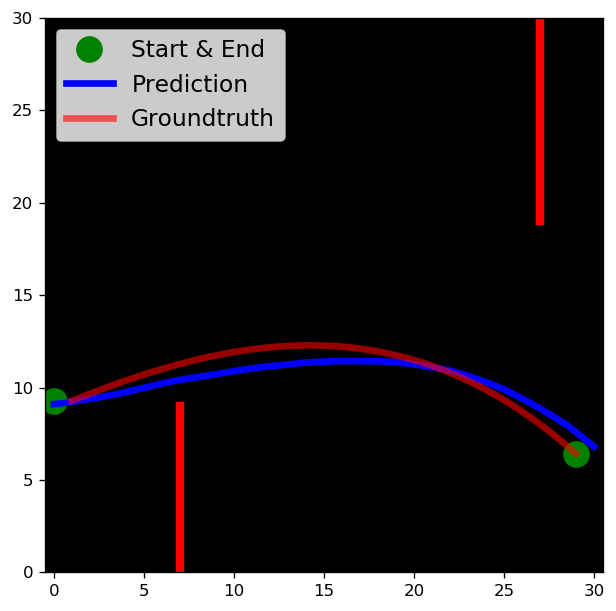

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6), dpi=env_dpi)
plt.xlim(-0.5, 30.5)
plt.ylim(0, 30)
frame = plt.gca()
frame.set_facecolor('black')

plt.plot([env_data.item()['x0'], env_data.item()['x0']], [0, env_data.item()['h0']], color='red', linewidth=5)
plt.plot([env_data.item()['x1'], env_data.item()['x1']], [30-env_data.item()['h1'], 30], color='red', linewidth=5)

plt.plot(0, val_tar_y[0,0,0]*30, 'go', markersize=15, label='Start & End')
plt.plot(29, val_tar_y[0,-1,0]*30, 'go', markersize=15)

plt.plot(torch.linspace(0, 1, 200)*30, p[0,:,0]*30, 'b', linewidth=4, label='Prediction', alpha=1)
plt.plot(val_tar_x[0,:,0]*30, val_tar_y[0,:,0]*30, 'r', linewidth=4, label='Groundtruth', alpha=0.6)

plt.legend(loc='upper left', fontsize=14)
plt.show()

In [18]:
p.shape

torch.Size([1, 200, 2])